In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

# 1. Load Data

In [19]:
phish = pd.read_csv("../data/feature_engineered_data_mn.csv")
phish.head()

,type,domain_age,domain_status,shortening_service,file_extension,domain_entropy,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_http,sensitive_words
0,2,486,2,0,6,3.375000,0,0,0,0,0,16,16,0,0
1,0,9214,2,0,5,3.277613,1,0,1,0,1,11,35,0,0
2,0,9234,2,0,5,3.235926,1,0,0,0,1,14,31,0,0
3,1,28,2,0,5,3.308751,7,4,9,0,1,21,88,1,0
4,1,160,2,0,5,3.501398,22,3,6,0,1,23,235,1,0


In [20]:
phish.tail()

,type,domain_age,domain_status,shortening_service,file_extension,domain_entropy,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_http,sensitive_words
159289,3,0,0,0,6,3.903208,16,0,0,0,0,34,34,1,0
159290,3,0,0,0,6,4.079679,16,0,0,0,0,34,34,1,0
159291,3,0,0,0,6,4.183542,12,0,0,0,0,36,36,1,0
159292,3,366,2,0,5,3.022055,3,0,0,0,1,12,86,1,0
159293,3,0,0,0,0,3.958229,11,0,0,0,0,27,27,1,0


# 2. Analyze Data

In [21]:
phish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159294 entries, 0 to 159293
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   type                      159294 non-null  int64  
 1   domain_age                159294 non-null  int64  
 2   domain_status             159294 non-null  int64  
 3   shortening_service        159294 non-null  int64  
 4   file_extension            159294 non-null  int64  
 5   domain_entropy            159294 non-null  float64
 6   digits_count              159294 non-null  int64  
 7   queries_count             159294 non-null  int64  
 8   special_characters_count  159294 non-null  int64  
 9   suspicious_query          159294 non-null  int64  
 10  is_common_tld             159294 non-null  int64  
 11  domain_length             159294 non-null  int64  
 12  url_length                159294 non-null  int64  
 13  is_http                   159294 non-null  i

In [22]:
classes = ['benign', 'defacement','phishing','malware']

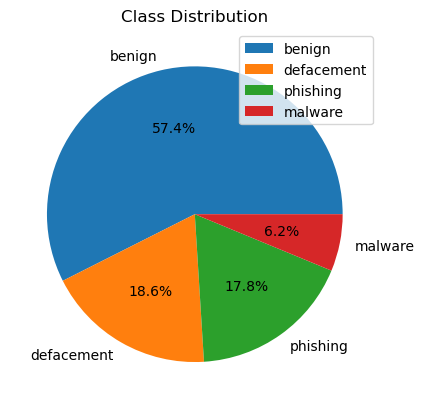

In [23]:
plt.pie(phish['type'].value_counts(), labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.legend()
plt.show()

In [24]:
phish['type'].value_counts()

type
0    91494
1    29554
2    28318
3     9928
Name: count, dtype: int64

## 3. Data Processing

In [25]:
phish.isna().sum()

type                        0
domain_age                  0
domain_status               0
shortening_service          0
file_extension              0
domain_entropy              0
digits_count                0
queries_count               0
special_characters_count    0
suspicious_query            0
is_common_tld               0
domain_length               0
url_length                  0
is_http                     0
sensitive_words             0
dtype: int64

In [26]:
# Remove duplicates
#phish = phish.drop_duplicates()

## Check for missing values and drop rows with missing values if necessary
#phish = phish.dropna()

## Verify the cleaned data
#phish.info()

In [27]:
phish['type'].value_counts()

type
0    91494
1    29554
2    28318
3     9928
Name: count, dtype: int64

## 4. Feature Selection

### 4.1 Function to extract features from URLs

###  Feature Importance Evaluation

In [28]:
from sklearn.model_selection import train_test_split
X= phish.drop('type', axis=1)
y = phish['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,domain_age,domain_status,shortening_service,file_extension,domain_entropy,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_http,sensitive_words
148097,9846,2,0,0,2.565448,0,0,0,0,1,13,82,0,0
7984,3286,2,0,1,4.015061,3,0,0,0,1,30,30,0,0
126619,1152,2,0,0,3.197160,0,0,0,0,0,18,35,1,0
19800,8737,2,0,5,2.872906,0,0,0,0,0,15,59,1,0
13105,10376,2,0,0,2.947703,0,0,0,0,1,9,36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310,439,2,0,0,3.614369,2,0,0,0,1,18,19,0,0
58654,5854,2,0,5,3.499228,8,4,8,0,1,21,140,1,0
83524,10859,2,0,0,3.506891,5,0,0,0,1,15,50,0,0
136499,6549,2,0,1,3.321928,0,0,0,0,1,10,10,0,0


## Machine Learning

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

classifier = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=200)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [30]:
print(
    f"Accuracy with Random Forest Classifier: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report with Random Forest Classifier:")
print(classification_report(y_test, y_pred))

Accuracy with Random Forest Classifier: 0.9480
Classification Report with Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     18137
           1       0.95      0.99      0.97      5868
           2       0.91      0.80      0.85      5804
           3       0.98      0.89      0.94      2050

    accuracy                           0.95     31859
   macro avg       0.95      0.92      0.93     31859
weighted avg       0.95      0.95      0.95     31859



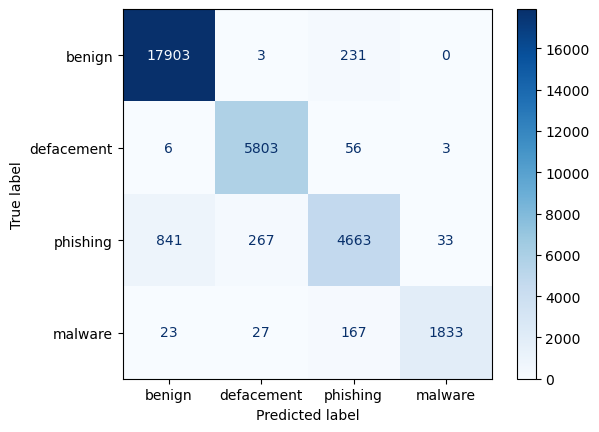

In [32]:
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Saving model

In [ ]:
import pickle

# Save the model to a file
#pickle.dump(classifier, open(f'../reports/random_forest_classifier_mn.pkl', 'wb'))


##